Loading data from parquet file...

Processing AAPL:
DataFrame shape: (1006, 6)
Column names: ['Close', 'High', 'Low', 'Volume', 'Open', 'Adj Close']
Array shapes:
Close: (1006,)
High: (1006,)
Low: (1006,)
Volume: (1006,)
All indicators calculated successfully for AAPL

Processing MSFT:
DataFrame shape: (1006, 6)
Column names: ['Close', 'High', 'Low', 'Volume', 'Open', 'Adj Close']
Array shapes:
Close: (1006,)
High: (1006,)
Low: (1006,)
Volume: (1006,)
All indicators calculated successfully for MSFT

Processing GOOGL:
DataFrame shape: (1006, 6)
Column names: ['Close', 'High', 'Low', 'Volume', 'Open', 'Adj Close']
Array shapes:
Close: (1006,)
High: (1006,)
Low: (1006,)
Volume: (1006,)
All indicators calculated successfully for GOOGL
price
[ 75.08750153  74.35749817  74.94999695 ... 193.1499939  193.58000183
 192.52999878]
entry
(array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]))
exit
(array([False, False, False, ..., False, Fal

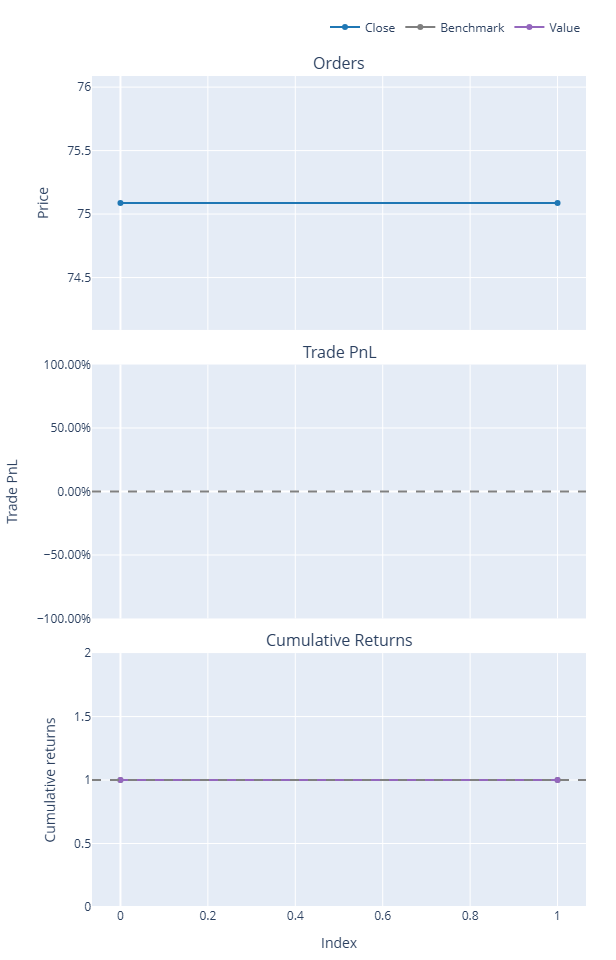

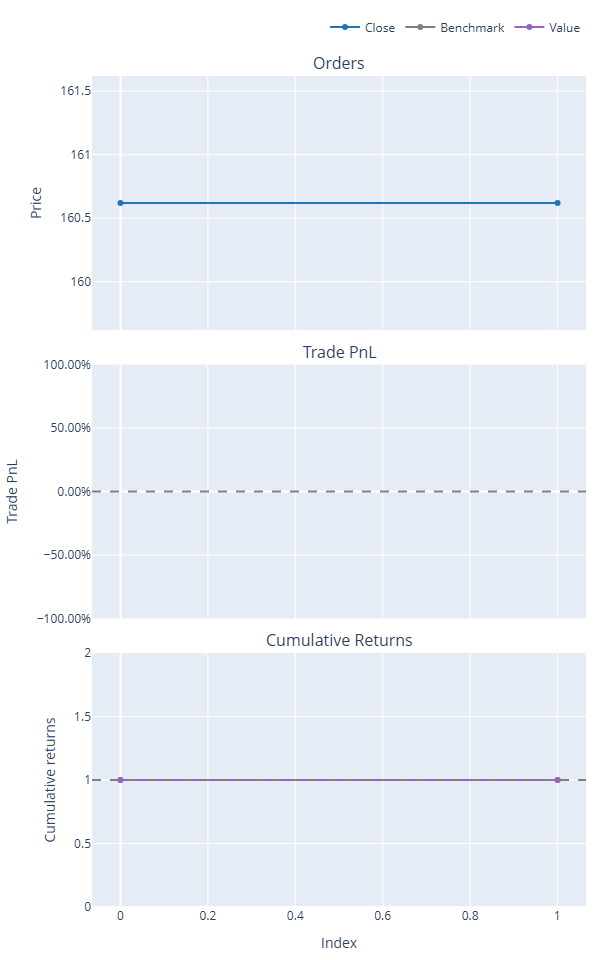

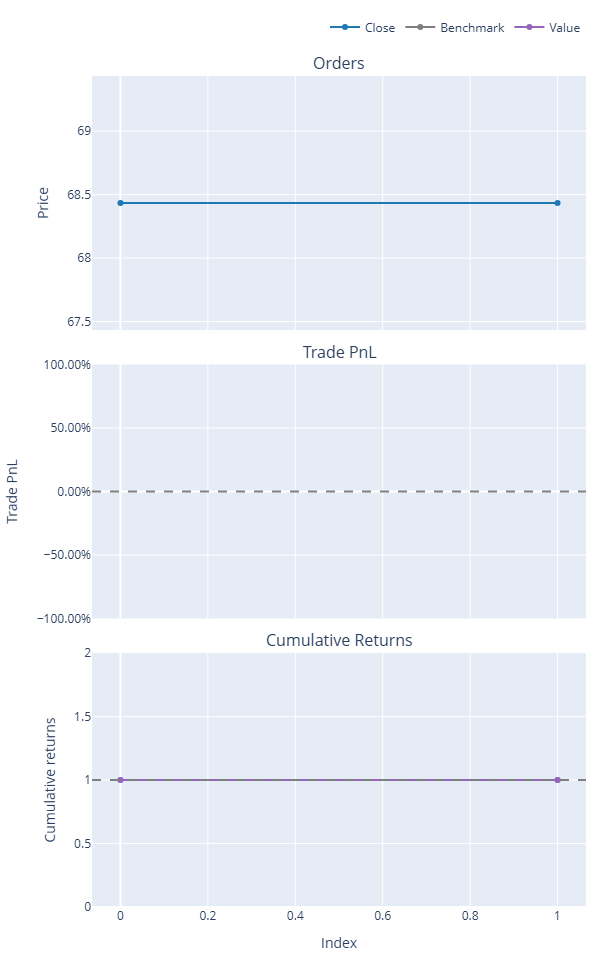

In [36]:
import talib
from pathlib import Path
import vectorbt as vbt
import os
import pandas as pd
import yfinance as yf
import numpy as np

class MultiStockBacktester:
    def __init__(self, symbols, start_date, end_date, data_path='stock_data.parquet'):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.data_path = data_path
        self.data = {}
        self.signals = {}
        self.results = {}

    def load_or_fetch_data(self, force_download=False):
        """Load data from parquet file if it exists, otherwise fetch from Yahoo Finance."""
        if not force_download and os.path.exists(self.data_path):
            print("Loading data from parquet file...")
            # Load the multi-index DataFrame
            combined_df = pd.read_parquet(self.data_path)
            
            # Store individual DataFrames for each symbol with proper column structure
            for symbol in self.symbols:
                symbol_data = pd.DataFrame()
                symbol_data['Close'] = combined_df[('Close', symbol)]
                symbol_data['High'] = combined_df[('High', symbol)]
                symbol_data['Low'] = combined_df[('Low', symbol)]
                symbol_data['Volume'] = combined_df[('Volume', symbol)]
                symbol_data['Open'] = combined_df[('Open', symbol)]
                symbol_data['Adj Close'] = combined_df[('Adj Close', symbol)]
                self.data[symbol] = symbol_data
            
        else:
            print("Fetching data from Yahoo Finance...")
            # Create an empty list to store DataFrames
            dfs = []
            
            # Download data for each symbol
            #for symbol in self.symbols:
            #    df = yf.download(symbol, start=self.start_date, end=self.end_date)
                # Add symbol to column names
                #df.columns = pd.MultiIndex.from_product([[col for col in df.columns], [symbol]])
            #    df['Symbol']=symbol
            #    df=df.set_index(['Symbol',df.index])
            #    dfs.append(df)
            combined_df = yf.download(self.symbols, start=self.start_date, end=self.end_date)
            # Combine all DataFrames
            #combined_df = pd.concat(dfs, axis=1)
            
            # Save to parquet
            #combined_df.to_parquet(self.data_path)
            combined_df.to_parquet(self.data_path)
            print(f"Data saved to {self.data_path}")
            
            # Store individual DataFrames for each symbol
            for symbol in self.symbols:
                symbol_data = pd.DataFrame()
                symbol_data['Close'] = combined_df[('Close', symbol)]
                symbol_data['High'] = combined_df[('High', symbol)]
                symbol_data['Low'] = combined_df[('Low', symbol)]
                symbol_data['Volume'] = combined_df[('Volume', symbol)]
                symbol_data['Open'] = combined_df[('Open', symbol)]
                symbol_data['Adj Close'] = combined_df[('Adj Close', symbol)]
                self.data[symbol] = symbol_data

    def calculate_indicators(self):
        """Calculate technical indicators for each symbol."""
        for symbol, df in self.data.items():
            print(f"\nProcessing {symbol}:")
            
            # Ensure data is clean and sorted
            df = df.sort_index()
            
            # Print data info for debugging
            print(f"DataFrame shape: {df.shape}")
            print("Column names:", df.columns.tolist())
            
            try:
                # Convert to numpy arrays and ensure correct dtype
                close = df['Close'].astype(float).to_numpy()
                high = df['High'].astype(float).to_numpy()
                low = df['Low'].astype(float).to_numpy()
                volume = df['Volume'].astype(float).to_numpy()
                
                # Print array shapes for debugging
                print(f"Array shapes:")
                print(f"Close: {close.shape}")
                print(f"High: {high.shape}")
                print(f"Low: {low.shape}")
                print(f"Volume: {volume.shape}")
                
                # Calculate indicators
                macd, macd_signal, _ = talib.MACD(close)
                rsi = talib.RSI(close)
                obv = talib.OBV(close, volume)
                slowk, slowd = talib.STOCH(high, low, close)
                
                # Store results
                self.signals[symbol] = {
                    'macd': pd.Series(macd, index=df.index),
                    'macd_signal': pd.Series(macd_signal, index=df.index),
                    'rsi': pd.Series(rsi, index=df.index),
                    'obv': pd.Series(obv, index=df.index),
                    'slowk': pd.Series(slowk, index=df.index),
                    'slowd': pd.Series(slowd, index=df.index)
                }
                
                print(f"All indicators calculated successfully for {symbol}")
                
            except Exception as e:
                print(f"Error calculating indicators for {symbol}: {str(e)}")
                continue

    def generate_entry_signals(self):
        """Generate combined entry signals based on multiple indicators."""
        for symbol in self.symbols:
            if symbol not in self.signals:
                continue
                    
            signals = self.signals[symbol]
            
            # Handle NaN values
            macd = signals['macd'].fillna(0)
            macd_signal = signals['macd_signal'].fillna(0)
            rsi = signals['rsi'].fillna(0)
            slowk = signals['slowk'].fillna(0)
            slowd = signals['slowd'].fillna(0)
            obv = signals['obv'].fillna(0)
            
            # MACD crossover
            macd_cross = (macd > macd_signal) & (macd.shift(1) <= macd_signal.shift(1))
            
            # RSI conditions
            rsi_buy = rsi < 50
            
            # Stochastic conditions
            stoch_buy = (slowk < 40) & (slowd < 40)
            
            # OBV trend
            obv_sma = obv.rolling(window=20, min_periods=1).mean()
            obv_trend = obv > obv_sma
            
            # Combined signal
            #entry_signal = macd_cross & rsi_buy & stoch_buy & obv_trend
            entry_signal = macd_cross & obv_trend
            
            # Clean up signal and ensure proper boolean array
            entry_signal = entry_signal.fillna(False).astype(bool).values
            
            # Get signal and exit array shape
            signal_shape = (len(entry_signal),)
            # Create clean entry signals using VectorBT
            entry_signal = vbt.signals.nb.clean_enex_1d_nb(
                entry_signal,  # raw entry signals
                np.full(signal_shape, False),  # exit signals (none for entries)
                #np.full(signal_shape, False)  # generate multiple entries (disabled)
                False
            )
            
            self.signals[symbol]['entry'] = entry_signal
                
    def generate_exit_signals(self):
        """Generate exit signals based on indicator conditions."""
        for symbol in self.symbols:
            if symbol not in self.signals:
                continue
                    
            signals = self.signals[symbol]
            
            # Handle NaN values
            rsi = signals['rsi'].fillna(0)
            slowk = signals['slowk'].fillna(0)
            slowd = signals['slowd'].fillna(0)
            macd = signals['macd'].fillna(0)
            macd_signal = signals['macd_signal'].fillna(0)
            
            # Exit conditions
            rsi_sell = rsi > 60
            stoch_sell = (slowk > 70) & (slowd > 70)
            macd_cross_below = (macd < macd_signal) & (macd.shift(1) >= macd_signal.shift(1))
            
            # Combined exit signal
            exit_signal = rsi_sell | stoch_sell | macd_cross_below
            
            # Clean up signal and ensure proper boolean array
            exit_signal = exit_signal.fillna(False).astype(bool).values
            
            # Get signal array shape
            signal_shape = (len(exit_signal),)
            # Create clean exit signals using VectorBT
            exit_signal = vbt.signals.nb.clean_enex_1d_nb(
                np.full(signal_shape, False),  # entry signals (none for exits)
                exit_signal,  # raw exit signals
                #np.full(signal_shape, False)  # generate multiple exits (disabled)
                True     
            )
            
            self.signals[symbol]['exit'] = exit_signal

    def run_backtest(self, initial_capital=100000, fee_rate=0.001):
        for symbol in self.symbols:
            if symbol not in self.signals:
                continue

            price = self.data[symbol]['Close'].to_numpy()
            entries = self.signals[symbol]['entry']
            exits = self.signals[symbol]['exit']
            print("price")
            print(price)
            print("entry")
            print(entries)
            print("exit")
            print(exits)
            portfolio = vbt.Portfolio.from_signals(
                price,
                entries,
                exits,
                init_cash=initial_capital,
                fees=fee_rate,
                freq='1D'
            )

            metrics = {
                'total_return': portfolio.total_return(),
                'sharpe_ratio': portfolio.sharpe_ratio(),
                'max_drawdown': portfolio.max_drawdown(),
                'win_rate': portfolio.trades.win_rate(),
                'profit_factor': portfolio.trades.profit_factor(),
                #'num_trades': portfolio.trades.num_trades()
            }

            self.results[symbol] = {
                'portfolio': portfolio,
                'metrics': metrics
            }

    def get_summary(self):
        summary = []
        for symbol in self.symbols:
            if symbol in self.results:
                metrics = self.results[symbol]['metrics'].copy()
                metrics['symbol'] = symbol
                summary.append(metrics)
        if not summary:
            return pd.DataFrame()
        return pd.DataFrame(summary).set_index('symbol')

def run_example():
    symbols = ['AAPL', 'MSFT', 'GOOGL']
    backtester = MultiStockBacktester(
        symbols=symbols,
        start_date='2020-01-01',
        end_date='2023-12-31',
        data_path='stock_data.parquet'
    )

    # Run analysis
    backtester.load_or_fetch_data(force_download=False)
    backtester.calculate_indicators()
    backtester.generate_entry_signals()
    backtester.generate_exit_signals()
    backtester.run_backtest(initial_capital=100000)

    # Get results
    summary = backtester.get_summary()
    print("\nBacktest Results Summary:")
    print(summary)

    # Plot results for each symbol
    for symbol in symbols:
        if symbol in backtester.results:
            portfolio = backtester.results[symbol]['portfolio']
            portfolio.plot(column=0).show()

if __name__ == "__main__":
    run_example()

In [17]:
import yfinance as yf
import numpy as np
import talib as tl
import vectorbt as vbt
import pandas as pd
import os
from numba import njit
os.environ["NUMBA_DISABLE_JIT"] = "0"

# Download historical data for multiple assets
symbols = ['HDFCBANK', 'TATAMOTORS', 'BHARTIARTL','TCS']
start_date = '2020-01-01'
end_date = '2024-01-01'
#data = yf.download(symbols, start=start_date, end=end_date)
df=pd.read_parquet(f'C:\\Users\\{os.getlogin()}\\OneDrive\\Python\\stockdata.parquet')
df=df[df['symbol'].isin(symbols)]
df=df.rename(columns={'epoch':'Date','symbol':'Ticker'})
df=df.set_index('Date')
df[['close','high','low','open']]=df[['close','high','low','open']].astype('float64')
df['volume']=df['volume'].astype('int')
data=df.pivot_table(index=df.index,columns=['Ticker'])
data.columns.names=['Price','Ticker']

@njit
def cust_ind(high,low,close,vol,fwin:int,swin:int):
    mo=vbt.MACD.run(close,fast_window=fwin,slow_window=swin,hide_params=['fast_window','slow_window'])
    macd,sig = mo.macd, mo.signal
    obv=vbt.OBV.run(close,vol,).obv
    obv_sma = obv.rolling(window=6, min_periods=1).mean()
    obv_trend = obv > obv_sma
    slowk, slowd=vbt.STOCH.run(high,low,close).percent_k,vbt.STOCH.run(high,low,close).percent_d
    macd_cross = (macd > sig) & (macd.shift(1) <= sig.shift(1))
    stoch_buy = (slowk < 30) & (slowd < 30)
    stoch_sell = (slowk >= 80) | (slowd >= 80)
    macd_below = (macd < sig) & (macd.shift(1) >= sig.shift(1))
    entry = macd_cross & obv_trend & stoch_buy
    exit = stoch_sell | macd_below
    entry, exit = entry.astype(bool), exit.astype(bool)
    return entry, exit

ind=vbt.IndicatorFactory(class_name="Combination",short_name="comb",input_names=['high','low','close','volume'],param_names=['fwin','swin'],
        output_names=['entry','exit']).from_apply_func(cust_ind)

res=ind.run(data['high'],data['low'],data['close'],data['volume'],fwin=[4,6,8,10,12],swin=[14,16,18,20,22])

entries = res.entry
exits = res.exit

if len(entries.shape) > 1:
    entries = entries.any(axis=1)  # Combine signals across parameters
if len(exits.shape) > 1:
    exits = exits.any(axis=1)
# Calculate returns
returns = data.pct_change()
weights = pd.Series([0.25, 0.25, 0.25, 0.25], index=symbols)
normalized_data = data['close'] / data['close'].iloc[0] * 100
portfolio_value = normalized_data.mul(weights, axis=1).sum(axis=1)
portfolio = vbt.Portfolio.from_signals(close=portfolio_value,entries= entries,exits=exit,init_cash=10000,freq='1D',direction='both',  # Allow both long and short positions
        size=1.0,  # Use full position size
        group_by=None,  # No grouping
        cash_sharing=False)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'MACD' of type Module(<module 'vectorbt' from 'C:\\Users\\mswas\\.conda\\envs\\alg\\Lib\\site-packages\\vectorbt\\__init__.py'>)
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_6148\3158075414.py", line 26:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\mswas\AppData\Local\Temp\ipykernel_6148\3158075414.py (26)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_6148\3158075414.py", line 26:[0m
[1m<source missing, REPL/exec in use?>[0m


In [18]:
exits

comb_fwin          4                                     6            \
comb_swin          14                                    16            
Ticker     BHARTIARTL HDFCBANK TATAMOTORS    TCS BHARTIARTL HDFCBANK   
Date                                                                   
2019-09-19      False    False      False  False      False    False   
2019-09-20      False    False      False  False      False    False   
2019-09-23      False    False      False  False      False    False   
2019-09-24      False    False      False  False      False    False   
2019-09-25      False    False      False  False      False    False   
...               ...      ...        ...    ...        ...      ...   
2024-12-02       True     True      False  False       True     True   
2024-12-03       True     True      False   True       True     True   
2024-12-04      False     True      False   True      False     True   
2024-12-05      False     True      False   True      False     True   
2024-12-06       True     True       True   True      False     True   

comb_fwin                            8                                     10  \
comb_swin                            18                                    20   
Ticker     TATAMOTORS    TCS BHARTIARTL HDFCBANK TATAMOTORS    TCS BHARTIARTL   
Date                                                                            
2019-09-19      False  False      False    False      False  False      False   
2019-09-20      False  False      False    False      False  False      False   
2019-09-23      False  False      False    False      False  False      False   
2019-09-24      False  False      False    False      False  False      False   
2019-09-25      False  False      False    False      False  False      False   
...               ...    ...        ...      ...        ...    ...        ...   
2024-12-02      False  False       True     True      False  False       True   
2024-12-03      False   True       True     True      False   True       True   
2024-12-04      False   True      False     True      False   True      False   
2024-12-05      False   True      False     True      False   True      False   
2024-12-06       True   True      False     True       True   True      False   

comb_fwin                                     12                             
comb_swin                                     22                             
Ticker     HDFCBANK TATAMOTORS    TCS BHARTIARTL HDFCBANK TATAMOTORS    TCS  
Date                                                                         
2019-09-19    False      False  False      False    False      False  False  
2019-09-20    False      False  False      False    False      False  False  
2019-09-23    False      False  False      False    False      False  False  
2019-09-24    False      False  False      False    False      False  False  
2019-09-25    False      False  False      False    False      False  False  
...             ...        ...    ...        ...      ...        ...    ...  
2024-12-02     True      False  False       True     True      False  False  
2024-12-03     True      False   True       True     True      False   True  
2024-12-04     True      False   True      False     True      False   True  
2024-12-05     True      False   True      False     True      False   True  
2024-12-06     True       True   True      False     True       True   True  

[1296 rows x 20 columns]

In [54]:
portfolio_value

epoch
2019-09-19    100.000000
2019-09-20    105.017353
2019-09-23    104.036880
2019-09-24    104.954269
2019-09-25    103.055996
                 ...    
2024-12-02    372.581921
2024-12-03    373.930332
2024-12-04    369.965942
2024-12-05    374.608215
2024-12-06    377.748135
Length: 1296, dtype: float64

In [18]:
portfolio.stats(agg_func=None).sort_values('Sharpe Ratio', ascending=False)

Start        End    Period  Start Value  \
comb_fwin comb_swin Ticker                                                
6         16        GOOG   2020-01-02 2023-12-29 1006 days      10000.0   
8         18        AMZN   2020-01-02 2023-12-29 1006 days      10000.0   
12        22        MSFT   2020-01-02 2023-12-29 1006 days      10000.0   
4         14        GOOG   2020-01-02 2023-12-29 1006 days      10000.0   
6         16        MSFT   2020-01-02 2023-12-29 1006 days      10000.0   
12        22        AMZN   2020-01-02 2023-12-29 1006 days      10000.0   
4         14        AMZN   2020-01-02 2023-12-29 1006 days      10000.0   
10        20        MSFT   2020-01-02 2023-12-29 1006 days      10000.0   
                    AAPL   2020-01-02 2023-12-29 1006 days      10000.0   
12        22        AAPL   2020-01-02 2023-12-29 1006 days      10000.0   
8         18        MSFT   2020-01-02 2023-12-29 1006 days      10000.0   
6         16        AMZN   2020-01-02 2023-12-29 1006 days      10000.0   
10        20        GOOG   2020-01-02 2023-12-29 1006 days      10000.0   
                    AMZN   2020-01-02 2023-12-29 1006 days      10000.0   
8         18        AAPL   2020-01-02 2023-12-29 1006 days      10000.0   
4         14        MSFT   2020-01-02 2023-12-29 1006 days      10000.0   
12        22        GOOG   2020-01-02 2023-12-29 1006 days      10000.0   
4         14        AAPL   2020-01-02 2023-12-29 1006 days      10000.0   
6         16        AAPL   2020-01-02 2023-12-29 1006 days      10000.0   
8         18        GOOG   2020-01-02 2023-12-29 1006 days      10000.0   

                               End Value  Total Return [%]  \
comb_fwin comb_swin Ticker                                   
6         16        GOOG    12337.398873         23.373989   
8         18        AMZN    12301.222622         23.012226   
12        22        MSFT    11073.840291         10.738403   
4         14        GOOG    13069.212485         30.692125   
6         16        MSFT    12353.741106         23.537411   
12        22        AMZN    11549.690439         15.496904   
4         14        AMZN    11736.912321         17.369123   
10        20        MSFT    10960.633573          9.606336   
                    AAPL    10868.176508          8.681765   
12        22        AAPL    10631.223674          6.312237   
8         18        MSFT    10643.656385          6.436564   
6         16        AMZN    10700.914382          7.009144   
10        20        GOOG    10302.011333          3.020113   
                    AMZN    10139.232043          1.392320   
8         18        AAPL    10049.341510          0.493415   
4         14        MSFT     9864.315879         -1.356841   
12        22        GOOG     9904.267109         -0.957329   
4         14        AAPL     9691.910217         -3.080898   
6         16        AAPL     9645.202920         -3.547971   
8         18        GOOG     8898.707556        -11.012924   

                            Benchmark Return [%]  Max Gross Exposure [%]  \
comb_fwin comb_swin Ticker                                                 
6         16        GOOG              114.190698                   100.0   
8         18        AMZN              114.190698                   100.0   
12        22        MSFT              114.190698                   100.0   
4         14        GOOG              114.190698                   100.0   
6         16        MSFT              114.190698                   100.0   
12        22        AMZN              114.190698                   100.0   
4         14        AMZN              114.190698                   100.0   
10        20        MSFT              114.190698                   100.0   
                    AAPL              114.190698                   100.0   
12        22        AAPL              114.190698                   100.0   
8         18        MSFT              114.190698                   100.0   
6         16        AMZN    

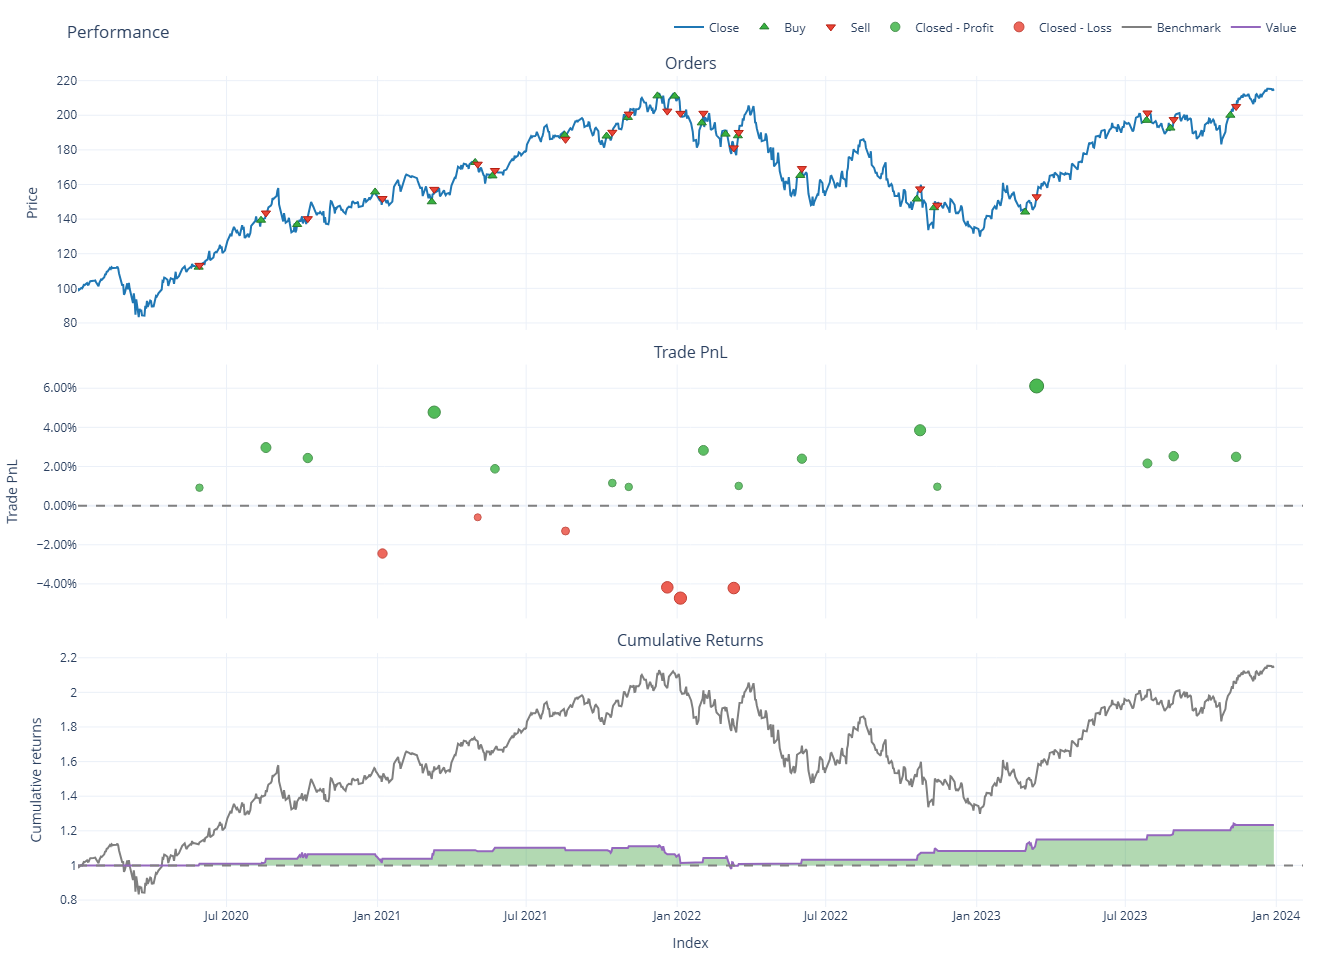

In [20]:
portfolio.plot(title='Performance',template='plotly_white',column=(6,16,'GOOG'),).show()

In [11]:
portfolio.plot(subplots=['drawdowns', 'underwater'],column=(4,14,'AMZN'))

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#9467bd'},
              'name': 'Value',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c1fe9781-012f-42ec-b183-15fe07fc4139',
              'x': array([datetime.datetime(2020, 1, 2, 0, 0),
                          datetime.datetime(2020, 1, 3, 0, 0),
                          datetime.datetime(2020, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 12, 27, 0, 0),
                          datetime.datetime(2023, 12, 28, 0, 0),
                          datetime.datetime(2023, 12, 29, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([10000.        , 10000.        , 10000.        , ..., 11454.42659172,
                          11454.42659172, 11454.42659172]),
              'yaxis': 'y'},
             {'customdata': array([[1],
                                   [2],
                                   [4],
           

In [88]:
portfolio.

Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2020-01-02,100.000000,100.000000,100.000000,100.000000
2020-01-03,99.019498,99.019498,99.019498,99.019498
2020-01-06,100.261611,100.261611,100.261611,100.261611
2020-01-07,99.955080,99.955080,99.955080,99.955080
2020-01-08,100.749911,100.749911,100.749911,100.749911
...,...,...,...,...
2023-12-22,215.364129,215.364129,215.364129,215.364129
2023-12-26,215.227399,215.227399,215.227399,215.227399
2023-12-27,214.645796,214.645796,214.645796,214.645796


In [81]:
data

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2020-01-02 AAPL     72.796028   75.087502   75.150002   73.797501   74.059998   
           AMZN     94.900497   94.900497   94.900497   93.207497   93.750000   
           GOOG     68.123726   68.368500   68.406998   67.077499   67.077499   
           MSFT    153.938202  160.619995  160.729996  158.330002  158.779999   
2020-01-03 AAPL     72.088287   74.357498   75.144997   74.125000   74.287498   
...                       ...         ...         ...         ...         ...   
2023-12-28 MSFT    373.240112  375.279999  376.459991  374.160004  375.369995   
2023-12-29 AAPL    191.591385  192.529999  194.399994  191.729996  193.899994   
           AMZN    151.940002  151.940002  153.889999  151.029999  153.100006   
           GOOG    140.425446  140.929993  141.434998  139.899994  140.679993   
           MSFT    373.996002  376.040009  377.160004  373.480011  376.000000   

Price                 Volume  
Date       Ticker             
2020-01-02 AAPL    135480400  
           AMZN     80580000  
           GOOG     28132000  
           MSFT     22622100  
2020-01-03 AAPL    146322800  
...                      ...  
2023-12-28 MSFT     14327000  
2023-12-29 AAPL     42628800  
           AMZN     39789000  
           GOOG     14872700  
           MSFT     18723000  

[4024 rows x 6 columns]